In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

Your challenge is to generate actionable, practical, and novel insights from horse tracking data that devises innovative and data-driven approaches to analyzing racing tactics, drafting strategies and path efficiency. There are several potential topics for participants to analyze.

These include, but are not limited to:

- Create a horse rating measuring expected finish position versus actual finish position. How does a horse’s expected finish position change through the running of a race? Does this metric rely solely on a horse’s own position or is it influenced by the position of competitors?
- What are optimal racing strategies? Considering different venues, surfaces and race distances. Create a jockey rating based upon path efficiency?
- Create a surface measure model which would rate the fairness of different paths on a racecourse that may be beneficial or harmful to finish position based. This may be a result of unknown barometric, weather or maintenance factors.
- Create a model measuring the existence (or not) and relevance of a drafting benefit.
- Create a model reveal optimal gait patterns. Does the model differ for such factors as age, distance, race section or surface?

In [2]:
races = pd.read_csv('data/nyra_race_table.csv')
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   track_id         2000 non-null   object
 1   race_date        2000 non-null   object
 2   race_number      2000 non-null   int64 
 3   distance_id      2000 non-null   int64 
 4   course_type      2000 non-null   object
 5   track_condition  2000 non-null   object
 6   run_up_distance  2000 non-null   int64 
 7   race_type        2000 non-null   object
 8   purse            2000 non-null   int64 
 9   post_time        2000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 156.4+ KB


In [3]:
starts = pd.read_csv('data/nyra_start_table.csv')
starts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   track_id        14915 non-null  object
 1   race_date       14915 non-null  object
 2   race_number     14915 non-null  int64 
 3   program_number  14915 non-null  object
 4   weight_carried  14915 non-null  int64 
 5   jockey          14915 non-null  object
 6   odds            14915 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 815.8+ KB


In [4]:
tracking = pd.read_csv('data/nyra_tracking_table.csv')
tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   track_id        object 
 1   race_date       object 
 2   race_number     int64  
 3   program_number  object 
 4   trakus_index    int64  
 5   latitude        float64
 6   longitude       float64
dtypes: float64(2), int64(2), object(3)
memory usage: 279.2+ MB


In [7]:
h_id = pd.read_csv('data/horse_ids.csv')
h_id = h_id[['track_id', 'race_date', 'race', 'program_number', 'horse_id', 'finishing_place']]
h_names = pd.read_csv('data/horse_names.csv')
h_names = h_names[['horse_id', 'horse_name']]
horses = pd.merge(h_id, h_names, how='left', on='horse_id')
horses = horses.rename(columns = {'race' : 'race_number'})
horses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14916 entries, 0 to 14915
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   track_id         14916 non-null  object
 1   race_date        14916 non-null  object
 2   race_number      14916 non-null  int64 
 3   program_number   14916 non-null  object
 4   horse_id         14916 non-null  int64 
 5   finishing_place  14916 non-null  int64 
 6   horse_name       14916 non-null  object
dtypes: int64(3), object(4)
memory usage: 932.2+ KB


In [8]:
starts['race_date'] = pd.to_datetime(starts['race_date'])
starts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   track_id        14915 non-null  object        
 1   race_date       14915 non-null  datetime64[ns]
 2   race_number     14915 non-null  int64         
 3   program_number  14915 non-null  object        
 4   weight_carried  14915 non-null  int64         
 5   jockey          14915 non-null  object        
 6   odds            14915 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 815.8+ KB


In [9]:
horses['race_date'] = pd.to_datetime(horses['race_date'])
horses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14916 entries, 0 to 14915
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         14916 non-null  object        
 1   race_date        14916 non-null  datetime64[ns]
 2   race_number      14916 non-null  int64         
 3   program_number   14916 non-null  object        
 4   horse_id         14916 non-null  int64         
 5   finishing_place  14916 non-null  int64         
 6   horse_name       14916 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 932.2+ KB


In [10]:
starts.agg(['min', 'max'])

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds
min,AQU,2019-01-01,1,1,110,Abner Adorno,0
max,SAR,2019-12-31,13,9,160,Winston R. Kay,19100


In [11]:
starts['program_number'] = starts['program_number'].str.strip()
starts_h = pd.merge(starts, horses, how='outer', on=['track_id', 'race_date', 'race_number', 'program_number'])
starts_h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14916 entries, 0 to 14915
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         14916 non-null  object        
 1   race_date        14916 non-null  datetime64[ns]
 2   race_number      14916 non-null  int64         
 3   program_number   14916 non-null  object        
 4   weight_carried   14915 non-null  float64       
 5   jockey           14915 non-null  object        
 6   odds             14915 non-null  float64       
 7   horse_id         14916 non-null  int64         
 8   finishing_place  14916 non-null  int64         
 9   horse_name       14916 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 1.3+ MB


In [12]:
starts_h.loc[starts_h['odds'].isnull()]

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,horse_id,finishing_place,horse_name
14915,BEL,2019-05-27,9,10,NaN,NaN,NaN,33,9,Stone Breaker


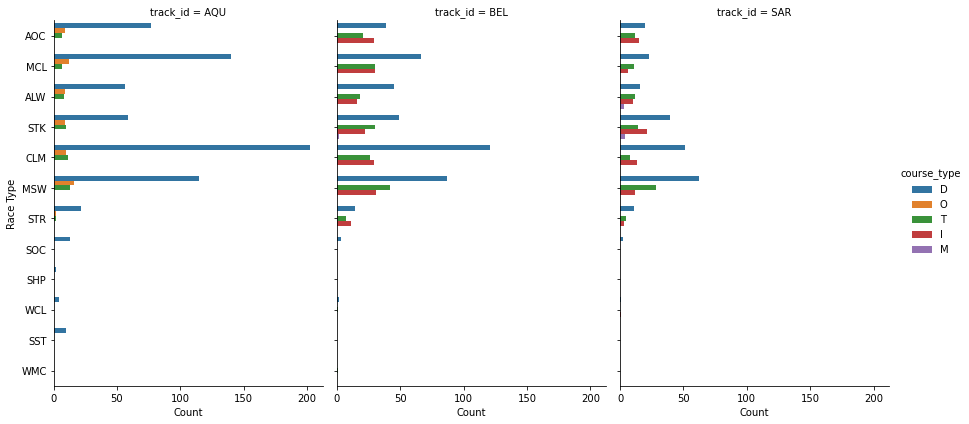

In [13]:
r_type = sns.catplot(y="race_type", hue="course_type", col="track_id",
                data=races, kind="count",
                height=6, aspect=.7);
r_type.set_axis_labels("Count", "Race Type");

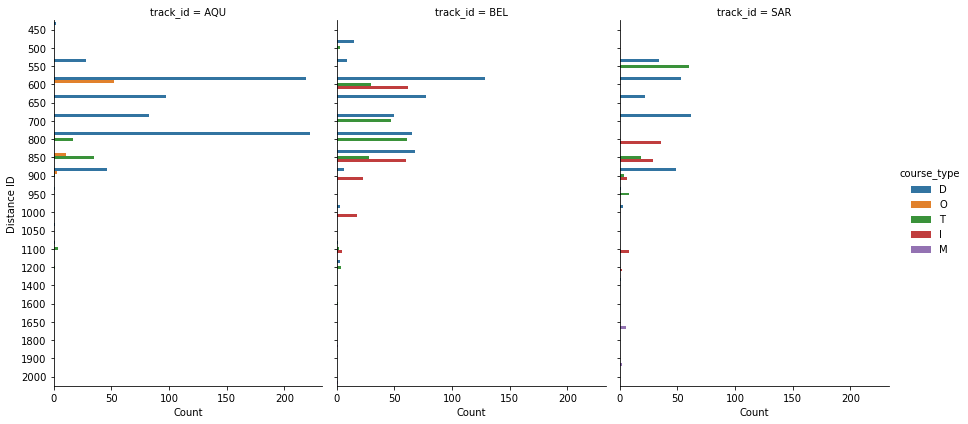

In [14]:
r_dist = sns.catplot(y="distance_id", hue="course_type", col="track_id",
                data=races, kind="count",
                height=6, aspect=.7);
r_dist.set_axis_labels("Count", "Distance ID");

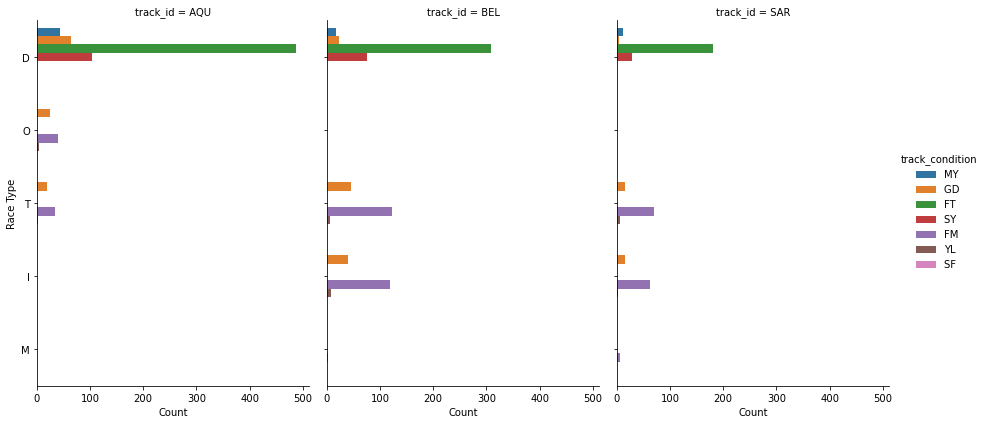

In [15]:
surface = sns.catplot(y="course_type", hue="track_condition", col="track_id",
                data=races, kind="count",
                height=6, aspect=.7);
surface.set_axis_labels("Count", "Race Type");

In [16]:
races['distance_id'].value_counts(normalize=True)

600     0.2725
800     0.2010
850     0.1245
700     0.1210
650     0.0980
900     0.0690
550     0.0655
1000    0.0120
1100    0.0105
500     0.0090
950     0.0050
1200    0.0050
1650    0.0025
450     0.0010
1900    0.0010
1600    0.0005
1800    0.0005
2000    0.0005
1050    0.0005
1400    0.0005
Name: distance_id, dtype: float64

In [17]:
races['course_type'].value_counts(normalize=True)

D    0.6755
T    0.1620
I    0.1245
O    0.0335
M    0.0045
Name: course_type, dtype: float64

In [18]:
starts_h.head(2)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,horse_id,finishing_place,horse_name
0,AQU,2019-01-01,1,1,123.0,Dylan Davis,130.0,1,2,Sounds Delicious
1,AQU,2019-01-01,1,2,120.0,Junior Alvarado,295.0,2,3,Crimson Frost


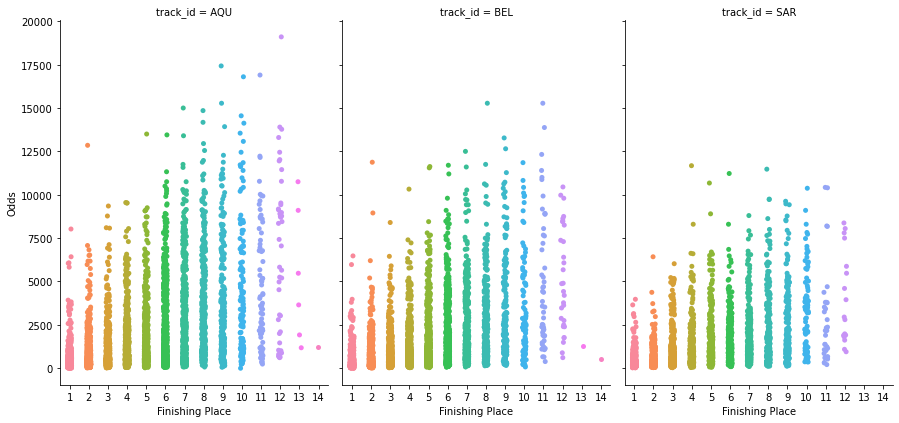

In [26]:
odds_placing = sns.catplot(y="odds", x="finishing_place", col="track_id",
                data=starts_h, kind="strip",
                height=6, aspect=.7)
odds_placing.set_axis_labels("Finishing Place", "Odds");

In [74]:
races['race_date'] = pd.to_datetime(races['race_date'])
ra_st_h = pd.merge(starts_h, races, how='left', on=['track_id', 'race_date', 'race_number'])
ra_st_h = ra_st_h.loc[ra_st_h['course_type'] != 'M']
ra_st_h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14843 entries, 0 to 14915
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         14843 non-null  object        
 1   race_date        14843 non-null  datetime64[ns]
 2   race_number      14843 non-null  int64         
 3   program_number   14843 non-null  object        
 4   weight_carried   14842 non-null  float64       
 5   jockey           14842 non-null  object        
 6   odds             14842 non-null  float64       
 7   horse_id         14843 non-null  int64         
 8   finishing_place  14843 non-null  int64         
 9   horse_name       14843 non-null  object        
 10  distance_id      14843 non-null  int64         
 11  course_type      14843 non-null  object        
 12  track_condition  14843 non-null  object        
 13  run_up_distance  14843 non-null  int64         
 14  race_type        14843 non-null  objec

In [75]:
ra_st_h['course_type'].value_counts()

D    9468
T    2776
I    1980
O     619
Name: course_type, dtype: int64

In [76]:
ra_st_h['finishing_place'].value_counts()

2     1991
3     1991
1     1991
4     1983
5     1936
6     1688
7     1254
8      867
9      574
10     314
11     157
12      88
13       7
14       2
Name: finishing_place, dtype: int64

In [77]:
top_finish = ra_st_h.loc[ra_st_h['finishing_place'] <= 3]
top_finish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5973 entries, 0 to 14910
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         5973 non-null   object        
 1   race_date        5973 non-null   datetime64[ns]
 2   race_number      5973 non-null   int64         
 3   program_number   5973 non-null   object        
 4   weight_carried   5973 non-null   float64       
 5   jockey           5973 non-null   object        
 6   odds             5973 non-null   float64       
 7   horse_id         5973 non-null   int64         
 8   finishing_place  5973 non-null   int64         
 9   horse_name       5973 non-null   object        
 10  distance_id      5973 non-null   int64         
 11  course_type      5973 non-null   object        
 12  track_condition  5973 non-null   object        
 13  run_up_distance  5973 non-null   int64         
 14  race_type        5973 non-null   object

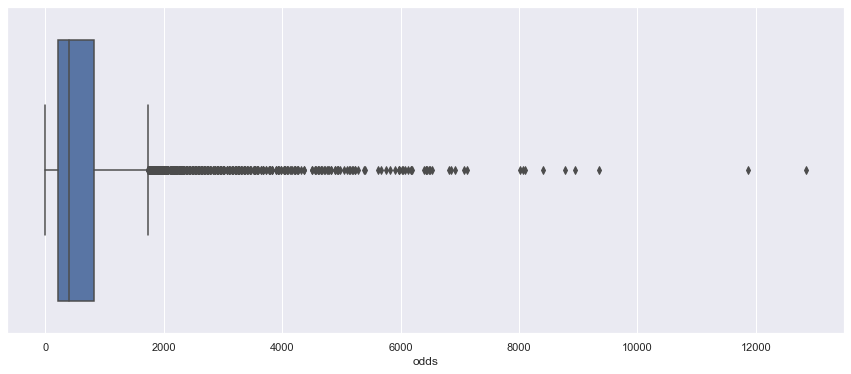

In [78]:
sns.set(rc={"figure.figsize":(15, 6)})
sns.boxplot(data=top_finish, x="odds");

In [79]:
top_stats = top_finish['odds'].describe().to_frame().reset_index()
top_stats

,index,odds
0,count,5973.000000
1,mean,694.731291
2,std,909.558506
3,min,0.000000
4,25%,210.000000
5,50%,395.000000
6,75%,820.000000
7,max,12850.000000


In [80]:
iqr = (top_stats.loc[top_stats["index"] == '75%', "odds"].values[0]) - (top_stats.loc[top_stats["index"] == '25%', 'odds'].values[0])
outlier = (top_stats.loc[top_stats["index"] == '75%', "odds"].values[0]) + 1.5*iqr
outlier

1735.0

In [81]:
long_odds = ra_st_h.loc[(ra_st_h['finishing_place'] <= 3) & (ra_st_h['odds'] > outlier)]
long_odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 54 to 14905
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   track_id         495 non-null    object        
 1   race_date        495 non-null    datetime64[ns]
 2   race_number      495 non-null    int64         
 3   program_number   495 non-null    object        
 4   weight_carried   495 non-null    float64       
 5   jockey           495 non-null    object        
 6   odds             495 non-null    float64       
 7   horse_id         495 non-null    int64         
 8   finishing_place  495 non-null    int64         
 9   horse_name       495 non-null    object        
 10  distance_id      495 non-null    int64         
 11  course_type      495 non-null    object        
 12  track_condition  495 non-null    object        
 13  run_up_distance  495 non-null    int64         
 14  race_type        495 non-null    object

In [82]:
long_odds.describe()

,race_number,weight_carried,odds,horse_id,finishing_place,distance_id,run_up_distance,purse,post_time
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000
mean,5.711111,119.482828,3070.212121,1556.139394,2.343434,719.090909,64.527273,9.129939e+04,420.931313
std,2.924727,3.283379,1483.379309,1221.525564,0.736025,137.921903,34.033544,1.459486e+05,275.098450
min,1.000000,111.000000,1740.000000,2.000000,1.000000,450.000000,20.000000,1.600000e+04,100.000000
25%,3.000000,118.000000,2050.000000,537.000000,2.000000,600.000000,45.000000,4.100000e+04,231.500000
50%,6.000000,120.000000,2575.000000,1188.000000,3.000000,700.000000,54.000000,6.000000e+04,358.000000
75%,8.000000,122.000000,3537.500000,2295.000000,3.000000,800.000000,76.000000,7.600000e+04,515.000000
max,13.000000,128.000000,12850.000000,4628.000000,3.000000,1600.000000,280.000000,1.500000e+06,1256.000000


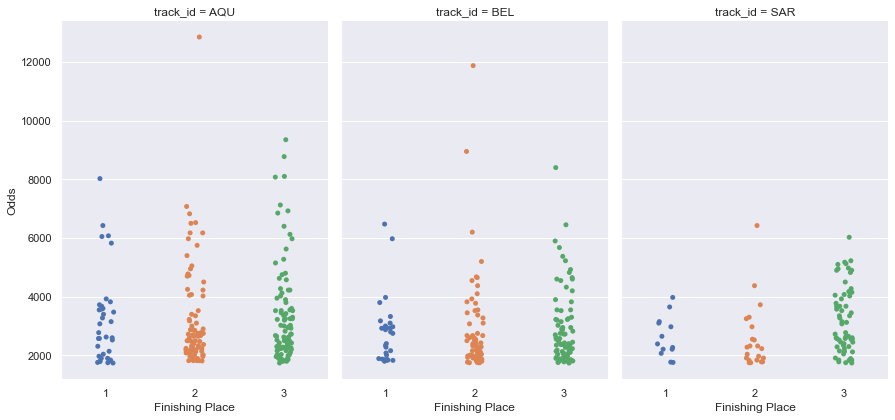

In [84]:
l_odds_placing = sns.catplot(y="odds", x="finishing_place", col="track_id",
                data=long_odds, kind="strip",
                height=6, aspect=.7)
l_odds_placing.set_axis_labels("Finishing Place", "Odds");

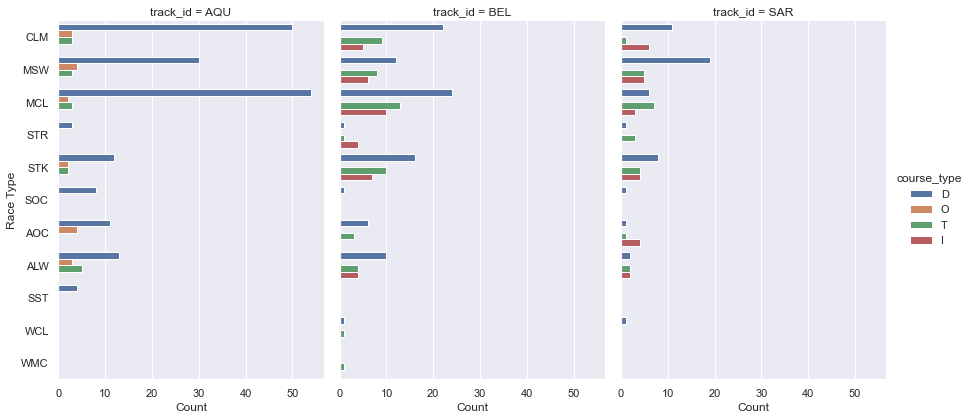

In [86]:
lo_type = sns.catplot(y="race_type", hue="course_type", col="track_id",
                data=long_odds, kind="count",
                height=6, aspect=.7);
lo_type.set_axis_labels("Count", "Race Type");

In [92]:
long_odds.groupby('track_id')['race_type'].value_counts(normalize=True)

track_id  race_type
AQU       MCL          0.269406
          CLM          0.255708
          MSW          0.168950
          ALW          0.095890
          STK          0.073059
          AOC          0.068493
          SOC          0.036530
          SST          0.018265
          STR          0.013699
BEL       MCL          0.262570
          CLM          0.201117
          STK          0.184358
          MSW          0.145251
          ALW          0.100559
          AOC          0.050279
          STR          0.033520
          WCL          0.011173
          SOC          0.005587
          WMC          0.005587
SAR       MSW          0.298969
          CLM          0.185567
          MCL          0.164948
          STK          0.164948
          ALW          0.061856
          AOC          0.061856
          STR          0.041237
          SOC          0.010309
          WCL          0.010309
Name: race_type, dtype: float64

In [94]:
ra_st_h.groupby('track_id')['race_type'].value_counts(normalize=True)

track_id  race_type
AQU       CLM          0.261832
          MCL          0.213859
          MSW          0.179616
          AOC          0.098853
          STK          0.094654
          ALW          0.091100
          STR          0.029074
          SOC          0.012922
          SST          0.012114
          WCL          0.004200
          SHP          0.001777
BEL       MSW          0.217777
          CLM          0.209993
          MCL          0.185735
          STK          0.127082
          ALW          0.105177
          AOC          0.103548
          STR          0.040369
          WCL          0.004345
          SOC          0.003802
          WMC          0.002172
SAR       MSW          0.280051
          CLM          0.175192
          STK          0.163683
          MCL          0.111893
          AOC          0.109335
          ALW          0.105818
          STR          0.044118
          WCL          0.006074
          SOC          0.003836
Name: race_type, dty

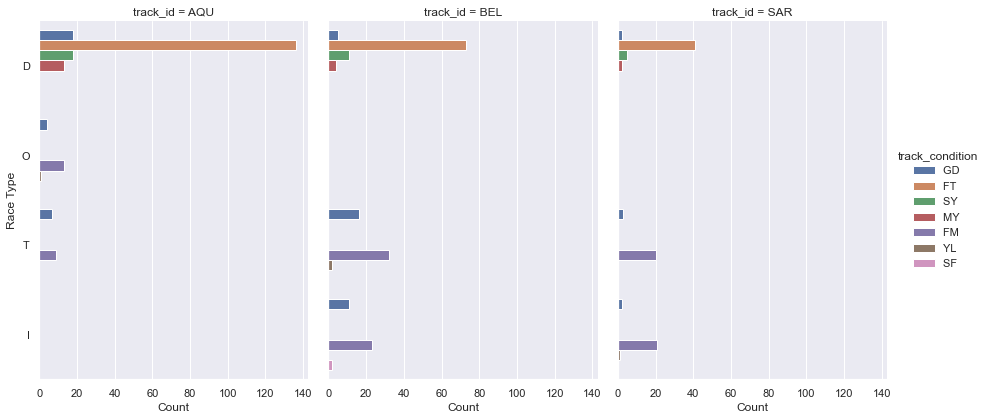

In [96]:
lo_surface = sns.catplot(y="course_type", hue="track_condition", col="track_id",
                data=long_odds, kind="count",
                height=6, aspect=.7);
lo_surface.set_axis_labels("Count", "Race Type");

In [113]:
lo_cond = long_odds.groupby('track_id')['track_condition'].value_counts(normalize=True).to_frame()
lo_cond.columns = ['proportion']
lo_cond = lo_cond.reset_index()
lo_cond['df_name'] = 'lo_cond'
lo_cond

,track_id,track_condition,proportion,df_name
0,AQU,FT,0.621005,lo_cond
1,AQU,GD,0.132420,lo_cond
2,AQU,FM,0.100457,lo_cond
3,AQU,SY,0.082192,lo_cond
4,AQU,MY,0.059361,lo_cond
5,AQU,YL,0.004566,lo_cond
6,BEL,FT,0.407821,lo_cond
7,BEL,FM,0.307263,lo_cond
8,BEL,GD,0.178771,lo_cond
9,BEL,SY,0.061453,lo_cond


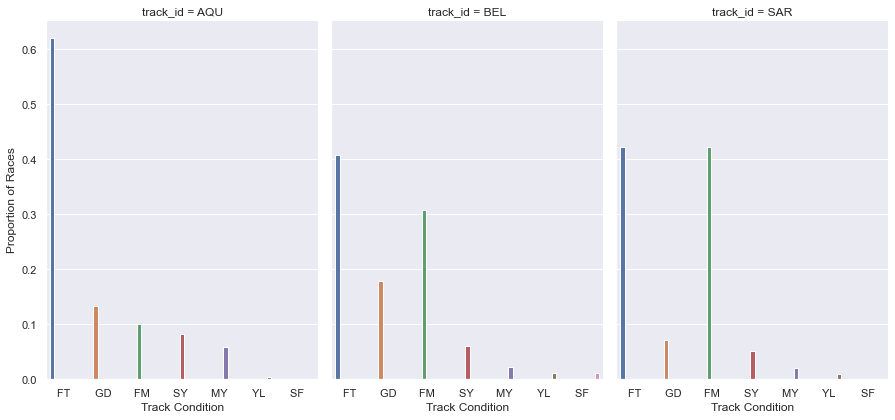

In [115]:
lo_co = sns.catplot(x="track_condition", y="proportion", hue="track_condition", col="track_id",
                data=lo_cond, kind="bar",
                height=6, aspect=.7)
lo_co.set_axis_labels("Track Condition", "Proportion of Races");

In [122]:
r_cond = ra_st_h.groupby('track_id')['track_condition'].value_counts(normalize=True).to_frame()
r_cond.columns = ['proportion']
r_cond = r_cond.reset_index()
r_cond['df_name'] = 'r_cond'
r_cond

,track_id,track_condition,proportion,df_name
0,AQU,FT,0.575997,r_cond
1,AQU,GD,0.141657,r_cond
2,AQU,FM,0.113067,r_cond
3,AQU,SY,0.112260,r_cond
4,AQU,MY,0.049427,r_cond
5,AQU,YL,0.007592,r_cond
6,BEL,FT,0.358255,r_cond
7,BEL,FM,0.349747,r_cond
8,BEL,GD,0.157676,r_cond
9,BEL,SY,0.092505,r_cond


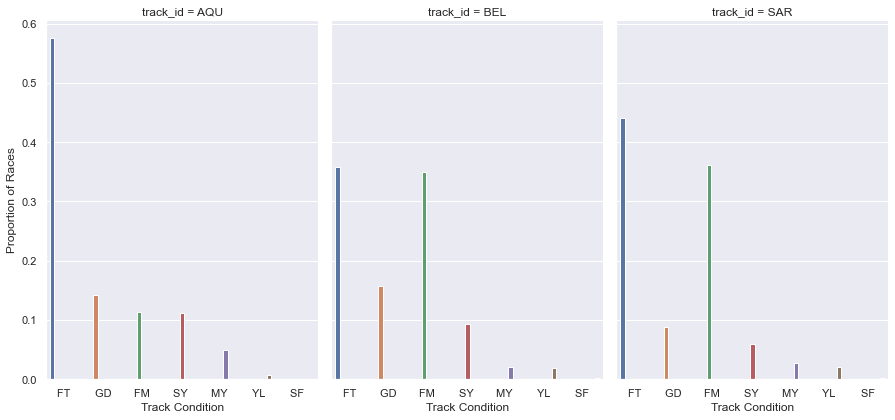

In [123]:
r_co = sns.catplot(x="track_condition", y="proportion", hue="track_condition", col="track_id",
                data=r_cond, kind="bar",
                height=6, aspect=.7)
r_co.set_axis_labels("Track Condition", "Proportion of Races");

In [125]:
cond_comp = pd.concat([lo_cond, r_cond])
cond_comp

,track_id,track_condition,proportion,df_name
0,AQU,FT,0.621005,lo_cond
1,AQU,GD,0.132420,lo_cond
2,AQU,FM,0.100457,lo_cond
3,AQU,SY,0.082192,lo_cond
4,AQU,MY,0.059361,lo_cond
5,AQU,YL,0.004566,lo_cond
6,BEL,FT,0.407821,lo_cond
7,BEL,FM,0.307263,lo_cond
8,BEL,GD,0.178771,lo_cond
9,BEL,SY,0.061453,lo_cond


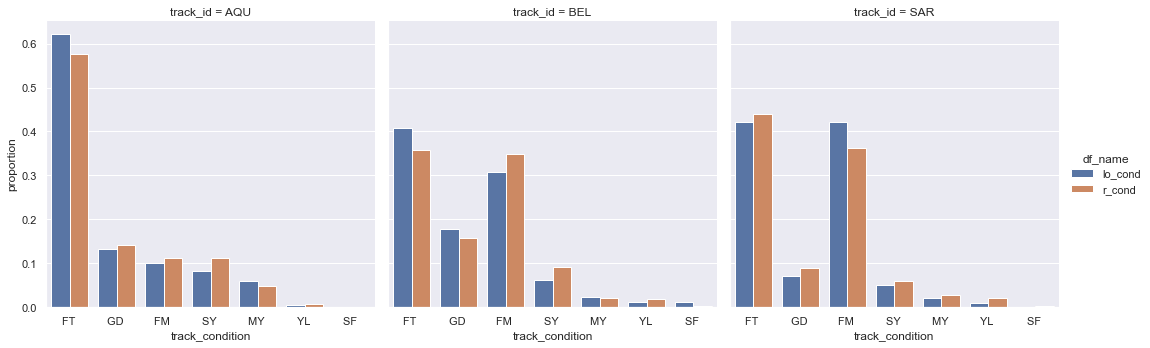

In [129]:
sns.catplot(x ='track_condition', y='proportion', hue='df_name', col='track_id',data=cond_comp, kind='bar');

### Scoring
An entry to the competition consists of a Notebook submission that is evaluated on the following five components, where 0 is the low score and 100 is the high score. Submissions will be judged based on how well they address:

#### Innovation (25 Points Total)
- Is this a novel way of looking at tracking data? (10 Pts)
- Are the statistical/machine learning approaches using the most up-to-date standards? (5 Pts)
- Will the conclusions challenge the status quo of horse racing methods? (10 Pts)

#### Relevance (30 Points Total)
- Can the conclusions influence equine welfare, equine performance or rider decision making? (10 Points)
- Can the conclusions be the basis of future research on future (larger, more granular) data sets? (10 Points)
- Are the conclusions something that horse racing participants (e.g. owners, trainers, veterinarians) can understand, digest and debate? (10 Points)

#### Competence (25 Points Total)
- Given the data, are the statistical models appropriate? (5 Points)
- Are the conclusions supported by the data? (10 Points)
- Is the analysis accurate? (10 Points)

#### Presentation (20 Points Total)
- Is the writing clear and free of nomenclature? (5 Points)
- Are the charts and tables provided interesting, visually appealing, and accurate? (5 Points)
- Can the analysis thread be followed throughout the presentation? (10 Points)


In [ ]:
complete = pd.read_csv('data/nyra_2019_complete.csv')
complete.info()